In [1]:
%config Completer.use_jedi = False

In [2]:
cd /home/jacob/PycharmProjects/glom-tensorflow/

/home/jacob/PycharmProjects/glom-tensorflow


In [3]:
ls

LICENSE  logs/  model.png  README.md  src/


In [6]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as tfkl
import tensorflow_datasets as tfds

from src.glom import GLOM

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import logging

warnings.filterwarnings('ignore')

### visualization functions

- `convertImageToOneHot`: don't use because real images should use sparse *distributed* representations
- `view_layer_states` simple `'e_norm'` plotter
- `NDtoRGB` linear projection
- `make_uniform` bring tensor to `[0,1)`
- `view_layer_states2` shows all layers plot `'x', 'e', 'e_norm'` and distplot for `'e_norm'`

In [29]:
def convertImageToOneHot(image, N=16):
    image = image[None, ...]
    image = image / 255.0
    image = image * N
    image = tf.cast(image, tf.int64)
    image = tf.one_hot(image, depth=N)
    image = tf.cast(image, tf.float32)

    # image = tf.tile(image[:, None, :, :, :], multiples=[1, T, 1, 1, 1])
    return image

In [30]:
def view_layer_states(layer_states):
    fig, axes = plt.subplots(1, len(layer_states))
    for (layer, state), axis in zip(layer_states.items(), axes):
        axis.imshow(state['e_norm'][0,:,:])
        axis.set_title(layer)
    plt.show()

In [31]:
def NDtoRGB(t):
    # get greatest divisor by 3
    t = tf.reshape(t[..., :3*(t.shape[-1] // 3)], 
                   t.shape[:-1] + [3, t.shape[-1] // 3])
    coefs = (tf.range(t.shape[-1], dtype=tf.float32))
    sum_coefs = tf.reduce_sum(coefs)
    return tf.reduce_sum(t * coefs / sum_coefs, axis=-1)

In [32]:
def make_uniform(t):
    minval = tf.reduce_min(t)
    maxval = tf.reduce_max(t)  
    return (t - minval) / (maxval - minval + 1e-6)

def view_layer_states2(layer_states):
    fig, axes = plt.subplots(nrows=4, ncols=len(layer_states), figsize=(7,7))

    for axes_row in axes[:-1]:
        for axis in axes_row:
            axis.xaxis.set_visible(False)
            axis.yaxis.set_visible(False)
    
    for i, (layer, state) in enumerate(layer_states.items()):
        axes[0, i].set_title(layer)
        
        x = make_uniform(NDtoRGB(layer_states[layer]['x'])[0])
        axes[0, i].imshow(x)
        
        e = make_uniform(NDtoRGB(layer_states[layer]['e'])[0])
        axes[1, i].imshow(e)
        
        e_norm = make_uniform(layer_states[layer]['e_norm'][0,:,:])
        axes[2, i].imshow(e_norm, cmap='gray')
        
        sns.distplot(tf.reshape(e_norm, (-1,)).numpy(), ax=axes[3, i])
        

    plt.subplots_adjust(wspace=.025, hspace=.025)
    plt.show()

### Load unstructured data dataset

I already have `imagenet_v2/topimages` downloaded on my laptop. I chose this dataset because of its diversity and small size (only ~1GB).

In [8]:
ds, info = tfds.load('imagenet_v2/topimages', with_info=True)

In [9]:
BATCH_SIZE = 32
H, W = 64, 96

resize_and_rescale = keras.Sequential([
  tfkl.experimental.preprocessing.Resizing(H, W, ),
  tfkl.experimental.preprocessing.Rescaling(1./255)
])
data_augmentation = keras.Sequential([
  tfkl.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tfkl.experimental.preprocessing.RandomRotation(0.2),
])

test_ds = ds['test']
test_ds = test_ds.take(1024)
test_ds = test_ds.map(lambda x: x['image'])
test_ds = test_ds.map(lambda x: resize_and_rescale(x[None, ...])[0] )
test_ds = test_ds.batch(BATCH_SIZE)
test_ds1 = test_ds.map(lambda x: data_augmentation(x))
test_ds = test_ds.concatenate(test_ds1)
#test_ds = test_ds.map(lambda t: tf.image.resize(t, size=(H, W), preserve_aspect_ratio=False))

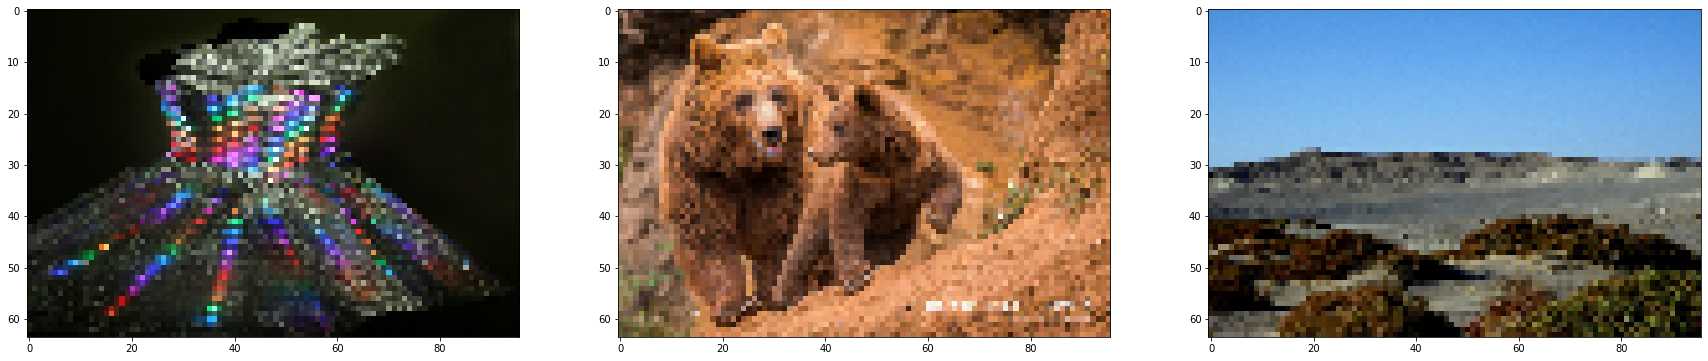

In [10]:
sample_images = next(iter(test_ds))
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
axes[0].imshow(sample_images[0])
axes[1].imshow(sample_images[8])
axes[2].imshow(sample_images[19])

### make SDR AE for image input

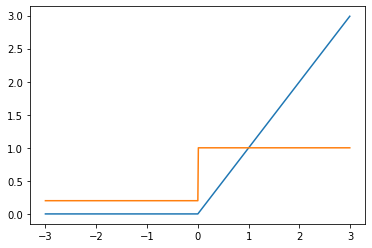

In [476]:
@tf.custom_gradient
def prenu(x):
    pos = tf.cast(x>=0., tf.float32)
    neg = 1. - pos
    
    def grad(dy):
        return pos + 0.2 * neg
    
    y = pos * x
    return y, grad

X = tf.range(-3, 3, 0.01)
with tf.GradientTape() as tape:
    tape.watch(X)
    Y = prenu(X)
grad = tape.gradient(Y, X)
plt.plot(X.numpy(), Y.numpy())
plt.plot(X.numpy(), grad.numpy())

In [664]:
class SparseDense(keras.Model):
    
    def __init__(self, d_out, hparams):
        """hparams must include:
            - activation_sparsity
            - rnd_neg_sparsity
            - ~~lambda_sparsity_mean~~
            - lambda_sparsity_kld
        """
        super(SparseDense, self).__init__()
        
        self.d_out = d_out
        self.hparams = hparams
        
    def build(self, input_shape):
        d_in = input_shape[-1]
        
        rnd = tf.random.uniform(shape=(d_in, self.d_out), 
                                minval=-1., maxval=1.)
        
        neg_mask_high = rnd <= (1. - 2 * self.hparams['activation_sparsity'])
        neg_mask_high = tf.cast(neg_mask_high, tf.float32)
        
        neg_mask_low = rnd >= (-1. + 2 * self.hparams['rnd_neg_sparsity'])
        neg_mask_low = tf.cast(neg_mask_low, tf.float32)
        
        mask = 1. - (neg_mask_high * neg_mask_low)
        
        self.W = mask * rnd + 1e-2 * tf.random.uniform(shape=(d_in, self.d_out))
        self.W = self.W / (self.hparams['activation_sparsity'])
        
        self.flatten_lyr = tfkl.Flatten()
        
    def call(self, inputs):
        outputs = self.hparams['activation_fn'](inputs @ self.W)
        
        flattened_outputs = self.flatten_lyr(outputs)  # [(B*X*Y*...), D]
        mean_activation = tf.reduce_mean(outputs, axis=0)  # [D]
        mean_activation = tf.clip_by_value(mean_activation, 0+1e-3, 1-1e-3)
        layer_kld = mean_activation * tf.math.log(mean_activation / self.hparams['activation_sparsity']) \
                  + (1. - mean_activation) * tf.math.log((1. - mean_activation) / (1. - self.hparams['activation_sparsity']))
        kld = tf.reduce_mean(layer_kld)
        self.add_loss(self.hparams['lambda_sparsity_kld'] * kld)
        
        self.mean_activation = mean_activation
        
        return outputs

In [686]:
class SAE2(keras.Model):

    def __init__(self, params):
        """params must contain:
            * d_enc
            * enc_activation
            * dec_activation
            * activation_sparsity
            * noise_coef
            * lambda_average_sparsity
            * lambda_individual_sparsity
        """
        super(SAE2, self).__init__()
        
        self.p = self.params = params
        
        self.encoder = None
        self.decoder = None
        
    def build(self, input_shape):
        self.encoder = tfkl.Dense(self.p['d_enc'],
                                  activation=self.p['enc_activation'],
                                  use_bias=False)
        self.encoder = tfkl.Dense(input_shape[-1],
                                  activation=self.p['dec_activation'],
                                  use_bias=False)
              
    def call(self, inputs):
        
        encoded = self.encoder(inputs)
        noisy_encoded = encoded + self.p['noise_coef'] * tf.random.uniform(encoded.shape)
        decoded = self.decoder(nonisy_encoded)
        
        # average sparsity loss
        average_sparsity = tf.reduce_mean(encoded)
        average_sparsity_deviation = (average_sparsity - self.p['activation_sparsity']) ** 2
        self.add_loss(self.p['lambda_average_sparsity'] * average_sparsity_deviation)
        
        # individual sparsity loss
        individual_sparsity = encoded * (1 - encoded)
        self.add_loss(self.p['lambda_individual_sparsity'] * individual_sparsity)
        
        # for later analysis
        self.encoded = encoded
        self.decoded = decoded
        
        return decoded
    
def clip01(x):
    return tf.clip_by_value(x, 0, 1)

sae2 = SAE2(dict(
    d_enc=16,
    enc_activation=clip01,
    dec_activation=tf.nn.relu,
    activation_sparsity=2./16.,
    noise_coef=0.05,
    lambda_average_sparsity=0.1,
    lambda_individual_sparsity=0.1,
))

sae2(tf.)

In [665]:
class SparseAutoencoder(keras.Model):

    def __init__(self, hparams):
        """hparams must contain:
            * d_enc
            * activation_fn
            * activation_sparsity
            * lambda_deviation
            ... whatever key-value pairs SparseDense looks for
        """
        super(SparseAutoencoder, self).__init__()
        
        self.hparams = hparams
        
        self.d_dec = None
        self.d_enc = self.hparams['d_enc']
        self.encoder = None
        self.decoder = None
        
    def build(self, input_shape):
        self.d_dec = input_shape[-1]
        
        self.encoder = SparseDense(d_out=self.d_enc, hparams=self.hparams)
        self.encoder.build(input_shape)
        
        self.W_dec = tf.linalg.pinv(self.encoder.W) 
        self.W_dec = self.W_dec + 0.1 * tf.random.uniform(self.W_dec.shape)
        self.W_dec = tf.Variable(self.W_dec)
        #self.decoder = tfkl.Dense(self.d_dec, activation=prenu, use_bias=False)
        
    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.hparams['activation_fn'](encoded @ self.W_dec)
        
        deviation = tf.reduce_mean((inputs - decoded) ** 2)
        self.add_loss(self.hparams['lambda_deviation'] * deviation)
        
        self.encoded = encoded
        self.decoded = decoded
        
        return decoded

In [109]:
ERR_MSG = "You are attempting to visualize a non-image tensor shaped %s"

def visualize_ae_results(orig, enc, dec, max_B=None):
    # all images must have a batch size of 2+
    assert orig.shape[-1] == 1 or orig.shape[-1] == 3, ERR_MSG % orig.shape
    
    B = orig.shape[0]
    if max_B is not None:
        B = max_B
    
    fig, axes = plt.subplots(B, 3, figsize=(9, 3*B))
    
    encoded_encoded_image = make_uniform(NDtoRGB(enc))
    encoded_decoded_image = make_uniform(dec)
    for b in range(B):        
        axes[b, 0].imshow(orig[b])
        axes[b, 1].imshow(encoded_encoded_image[b])
        axes[b, 2].imshow(encoded_decoded_image[b])
        
    plt.show()

19/19 [==============================] - 0s 810us/step - loss: 0.0959
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


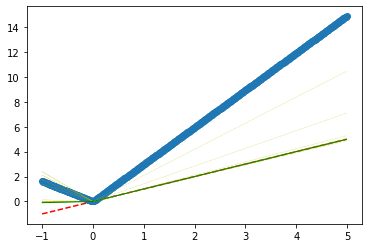

In [680]:
ae1 = SparseAutoencoder(dict(
    d_enc=64,
    activation_fn=lrelu,
    activation_sparsity=0.2,
    rnd_neg_sparsity=0.05,
    lambda_deviation=1.,
    lambda_sparsity_kld=0.01,
))

X = tf.range(-1, 5, delta=1e-2)[:, None]
Y = X
plt.plot(X, X, 'r--')
plt.plot(X, ae1(X), 'o')

ae1.compile('adam', 'mse')

W_old=ae1.encoder.W[0].numpy()
for epoch in range(100):
    ae1.fit(X, Y)
    if epoch < 5 or epoch % 5 == 0:
        plt.plot(X, ae1(X), 'y', linewidth=0.25, linestyle='dashed')
    
W_new=ae1.encoder.W[0].numpy()
print((W_new-W_old))
plt.plot(X, ae1(X), 'g', linewidth=1.0)

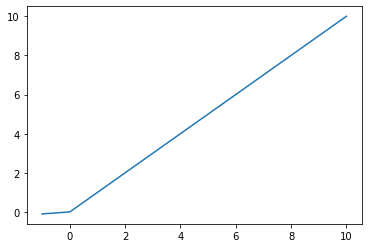

In [682]:
X_test = tf.range(-1, 10, 0.001)[..., None]
plt.plot(X_test, ae1(X_test))

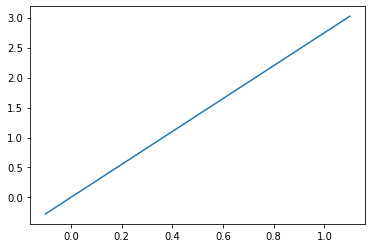

trial 0: lr=0.001


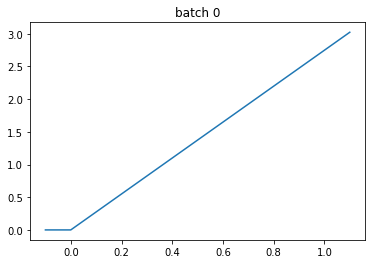

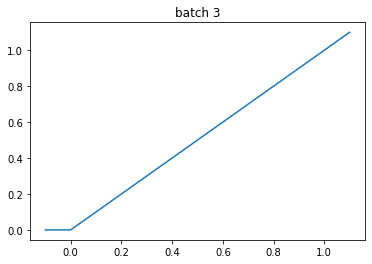

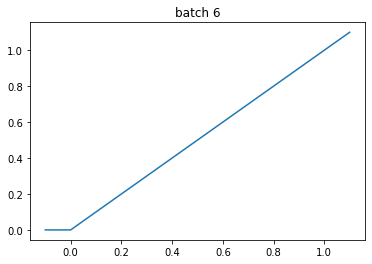

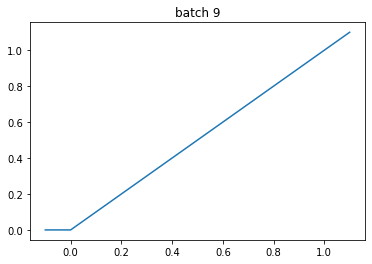

trial 1: lr=0.005


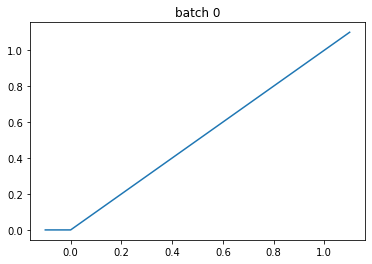

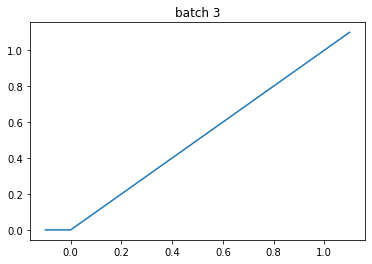

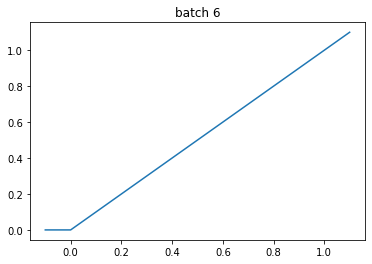

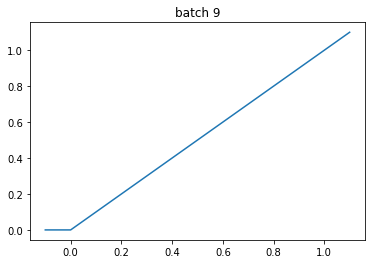

trial 2: lr=0.01


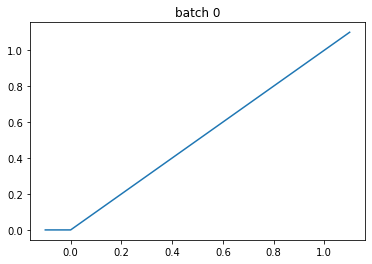

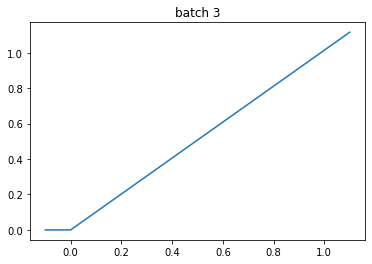

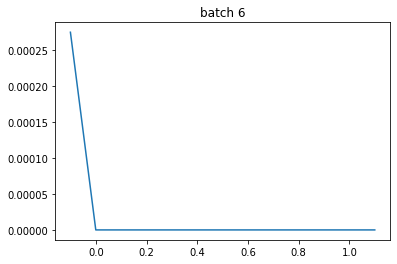

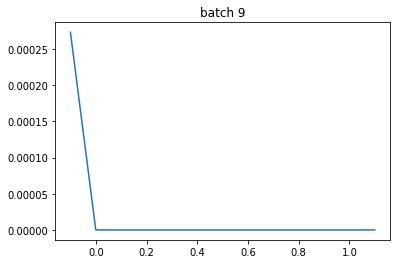

trial 3: lr=0.02


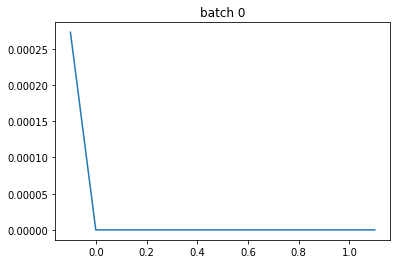

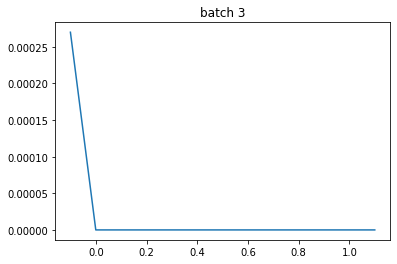

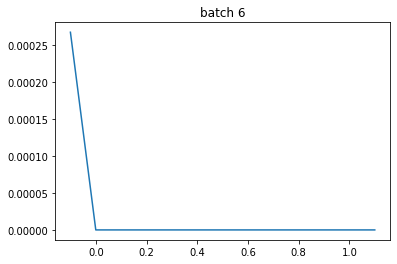

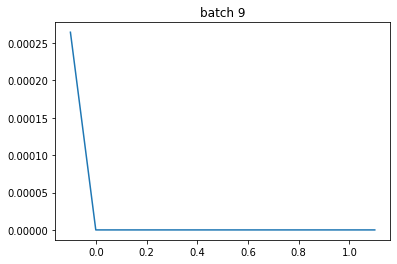

In [305]:
X = tf.range(-0.1, 1.1, 1e-2)[:, None]

M = tf.Variable(tf.random.uniform((1, 32)))
Mp = tf.Variable(tf.linalg.pinv(M) + 0.2 * tf.random.uniform((32, 1)))


Y = ((X @ M) @ Mp)
plt.plot(X, Y)
plt.show()

for trial_num, lr in enumerate([0.001, 0.005, 0.01, 0.02]):
    opt = tf.optimizers.SGD(lr)
    print(f'trial {trial_num}: lr={lr}')
    for b in range(10):
        with tf.GradientTape() as tape:
            tape.watch([M, Mp])
            Y = tf.nn.relu(tf.nn.relu(X @ M) @ Mp)
            err = (Y-X)**2
        grads = tape.gradient(err, [M, Mp])
        opt.apply_gradients(zip(grads, [M, Mp]))
        if b % 3 == 0:
            plt.plot(X, Y)
            plt.title(f'batch {b}')
            plt.show()

4/4 [==============================] - 0s 2ms/step - loss: 1040.3015


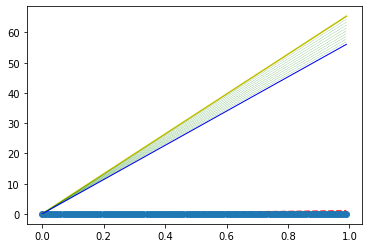

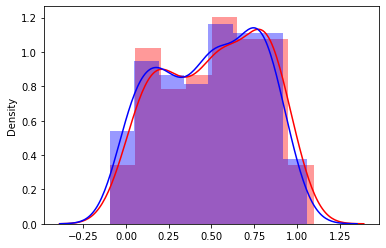

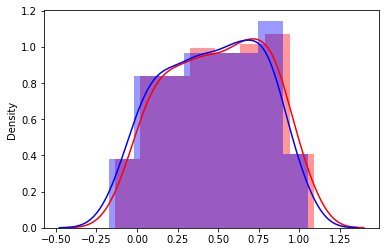

In [423]:
X = tf.range(0.0, 1.0, 1e-2)[:, None]
Y = X

H = 2**8

model = keras.Sequential([
    tfkl.Dense(H, activation='relu', use_bias=False),
    tfkl.Dense(1, activation='relu', use_bias=False),
])


model.compile('adam', 'mse')

plt.plot(X, Y, 'r--')
plt.plot(X, model(X), 'o')
model.layers[0].weights[0].assign_add(tf.random.uniform((1, H)))
model.layers[1].weights[0].assign_add(tf.random.uniform((H, 1)))
plt.plot(X, model(X), 'y')

w_enc_pre = model.layers[0].weights[0].numpy()[0, ...]
w_dec_pre = model.layers[1].weights[0].numpy()[..., 0]

for epoch in range(10):
    model.fit(X, Y)

    plt.plot(X, model(X), 'g', linewidth=0.25, linestyle='dashed')
    
plt.plot(X, model(X), color='b', linewidth=1)
plt.show()

w_enc_post = model.layers[0].weights[0].numpy()[0, ...]
w_dec_post = model.layers[1].weights[0].numpy()[..., 0]

sns.distplot(w_enc_pre, color='red')
sns.distplot(w_enc_post, color='blue')
plt.show()
sns.distplot(w_dec_pre, color='red')
sns.distplot(w_dec_post, color='blue')
plt.show()

In [610]:
def show_samples(ofset=0):
    N_samples = 2
    sample_origonals = sample_images[ofset:ofset+N_samples]
    sample_shape = sample_origonals.shape
    sample_origonals = tf.reshape(sample_origonals, shape=(-1, 3))
    sample_reconstructions = sparse_rgb_ae(sample_origonals)
    sample_origonals = tf.reshape(sample_origonals, shape=sample_shape)
    sample_reconstructions = tf.reshape(sample_reconstructions, shape=sample_shape)
    fig, axes = plt.subplots(N_samples, 2, figsize=(2*5, N_samples*5))
    for i in range(N_samples):
        axes[i, 0].imshow(sample_origonals[i])
        axes[i, 1].imshow(sample_reconstructions[i])
    plt.show()

train_ds = test_ds.take(32) \
                  .map(lambda x: tf.reshape(x, (-1, x.shape[-1]))) \
                  .map(lambda x: (x, x))

lr=0.001
pre mod
32/32 [==============================] - 2s 54ms/step - loss: 0.2183
post mod
32/32 [==============================] - 3s 106ms/step - loss: 1.4105e-05
lr=0.005
pre mod
32/32 [==============================] - 2s 62ms/step - loss: 0.2040
post mod
32/32 [==============================] - 4s 108ms/step - loss: 4.2718e-06
lr=0.01
pre mod
32/32 [==============================] - 2s 70ms/step - loss: 0.2199
post mod
32/32 [==============================] - 4s 108ms/step - loss: 1.8819e-06
lr=0.05
pre mod
32/32 [==============================] - 2s 65ms/step - loss: 0.2380
post mod
32/32 [==============================] - 4s 109ms/step - loss: 3.5810e-06
lr=0.1
pre mod
32/32 [==============================] - 2s 64ms/step - loss: 0.2926
post mod
32/32 [==============================] - 4s 107ms/step - loss: 6.8017e-06


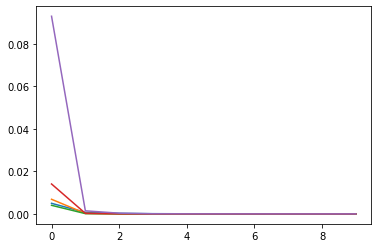

In [623]:
H = 64

def lrelu(x): 
    return tf.nn.leaky_relu(x, alpha=0.05)

for lr in [0.001, 0.005, 0.01, 0.05, 0.1]:
    print(f'lr={lr}')
    
    sparse_rgb_ae = keras.Sequential([
        tfkl.Dense(H, activation=lrelu, use_bias=False,
                   kernel_initializer='glorot_uniform'),
        #tfkl.BatchNormalization(),
        tfkl.Dense(3, activation=lrelu, use_bias=False,
                   kernel_initializer='glorot_uniform'),
    ])

    def elementwise_loss(ytrue, ypred):
        diff = ytrue - ypred
        return tf.reduce_mean(diff ** 2)

    sparse_rgb_ae.compile(keras.optimizers.Adam(lr), loss=elementwise_loss)

    print('pre mod')
    sparse_rgb_ae.evaluate(train_ds)
    #show_samples()

    sparse_rgb_ae.layers[0].weights[0].assign(
        tf.sign(tf.reduce_sum(sparse_rgb_ae.layers[0].weights[0], axis=-1))[:, None]
        * sparse_rgb_ae.layers[0].weights[0])

    sparse_rgb_ae.layers[-1].weights[0].assign(tf.Variable(
        tf.linalg.pinv(sparse_rgb_ae.layers[0].weights[0])))

    print('post mod')
    sparse_rgb_ae.evaluate(train_ds)
    #show_samples()

    loss_vals = []
    for b in range(10):
        history=sparse_rgb_ae.fit(train_ds)
        loss_vals.append(history.history['loss'])
        
    plt.plot(loss_vals)

pre mod
32/32 [==============================] - 2s 49ms/step - loss: 0.2239
post mod
32/32 [==============================] - 2s 52ms/step - loss: 0.1983


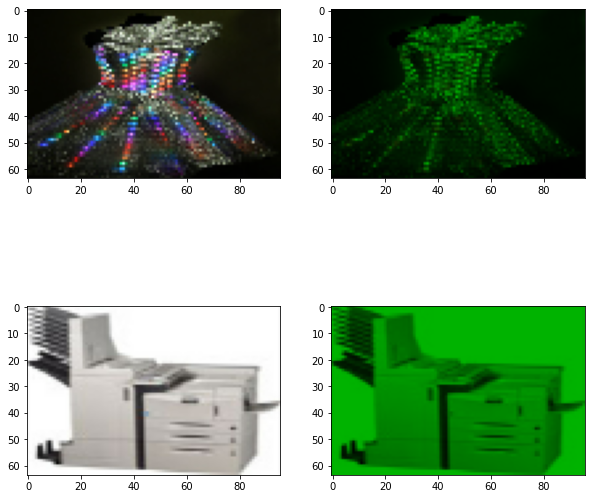

Epoch 1/10
32/32 [==============================] - 3s 102ms/step - loss: 0.0501
Epoch 2/10
32/32 [==============================] - 3s 96ms/step - loss: 0.0024
Epoch 3/10
32/32 [==============================] - 3s 98ms/step - loss: 1.9188e-04
Epoch 4/10
32/32 [==============================] - 3s 100ms/step - loss: 4.8152e-05
Epoch 5/10
32/32 [==============================] - 3s 96ms/step - loss: 3.4820e-05
Epoch 6/10
32/32 [==============================] - 3s 98ms/step - loss: 2.8352e-05
Epoch 7/10
32/32 [==============================] - 4s 115ms/step - loss: 2.4156e-05
Epoch 8/10
32/32 [==============================] - 4s 113ms/step - loss: 2.0917e-05
Epoch 9/10
32/32 [==============================] - 4s 114ms/step - loss: 1.8537e-05
Epoch 10/10
32/32 [==============================] - 4s 110ms/step - loss: 1.6875e-05


In [632]:
sparse_rgb_ae = keras.Sequential([
    tfkl.Dense(H, activation=lrelu, use_bias=False,
               kernel_initializer='glorot_uniform'),
    #tfkl.BatchNormalization(),
    tfkl.Dense(3, activation=lrelu, use_bias=False,
               kernel_initializer='glorot_uniform'),
])

def elementwise_loss(ytrue, ypred):
    diff = ytrue - ypred
    return tf.reduce_mean(diff ** 2)

sparse_rgb_ae.compile(keras.optimizers.Adam(0.02), loss=elementwise_loss)

print('pre mod')
sparse_rgb_ae.evaluate(train_ds)
#show_samples()

sparse_rgb_ae.layers[0].weights[0].assign(
    tf.sign(tf.reduce_sum(sparse_rgb_ae.layers[0].weights[0], axis=-1))[:, None]
    * sparse_rgb_ae.layers[0].weights[0])

#sparse_rgb_ae.layers[-1].weights[0].assign(tf.Variable(
#    tf.linalg.pinv(sparse_rgb_ae.layers[0].weights[0])))

print('post mod')
sparse_rgb_ae.evaluate(train_ds)
#show_samples()

def scheduler(epoch, lr):
    if epoch < 2:
        return 0.01
    elif 2 <= epoch <= 7:
        return 0.01 * tf.math.exp((epoch - 2) * (-0.2))
    else:
        return 0.01 * tf.math.exp((8 - 2) * (-0.2))
    
cb = keras.callbacks.LearningRateScheduler(scheduler)

loss_vals = []
history = sparse_rgb_ae.fit(train_ds, callbacks=[cb], epochs=10)

In [633]:
history.history['lr']

[0.01,
 0.01,
 0.01,
 0.008187308,
 0.0067032003,
 0.005488116,
 0.0044932896,
 0.0036787945,
 0.003011942,
 0.003011942]

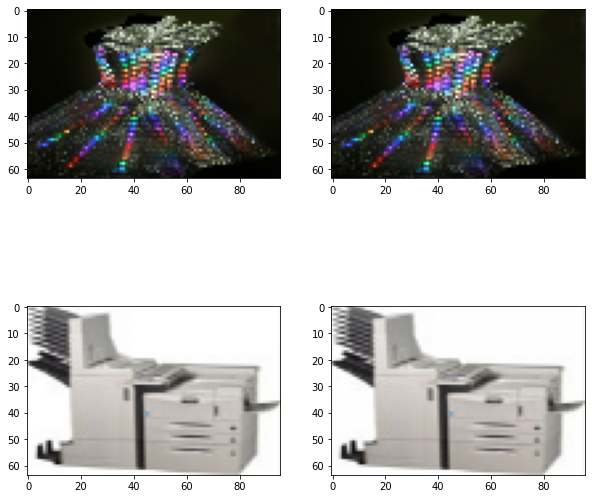

In [634]:
show_samples()

In [603]:
W_enc = sparse_rgb_ae.layers[0].weights[0]
W_dec = sparse_rgb_ae.layers[-1].weights[0]

print(W_enc.shape)
print(tf.reduce_mean(W_enc, axis=-1))
print(tf.reduce_mean(W_dec, axis=0))

(3, 64)
tf.Tensor([0.05664806 0.03825551 0.06206152], shape=(3,), dtype=float32)
tf.Tensor([0.02459843 0.01857283 0.02220896], shape=(3,), dtype=float32)


Lessons: keep the derivative strong below zero. prenu and relu failed because they had 'dead' units with little or no gradient to resurrect them. On the other hand, try to reasonably minimize the negative regime as maximum asymetry creates maximum representitive power.

Now I want to explore the SDR's created by the encoder

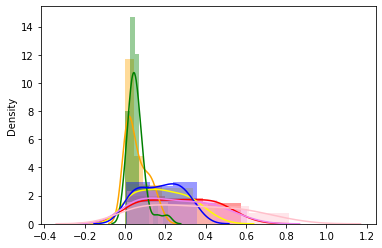

array([[ 1.10185467e-01,  8.73125251e-03,  5.70574217e-02,
         4.15999927e-02,  7.91028813e-02,  8.78187194e-02,
        -3.14182765e-03,  1.15775868e-01,  1.61624688e-03,
         4.13325131e-02,  5.39291985e-02,  2.15907749e-02,
         4.76748571e-02,  3.65641527e-02,  5.62206202e-04,
        -2.52092979e-03,  5.33217266e-02, -2.67495867e-03,
         6.40924871e-02,  3.96868438e-02,  1.93326995e-02,
        -3.62631370e-04,  2.35818746e-03, -1.37857301e-03,
         1.97623447e-02, -2.76080216e-04,  3.47327292e-02,
        -3.89992748e-03, -3.57695739e-03,  1.77475139e-02,
         4.65995036e-02,  1.18676908e-02,  7.99588219e-04,
         3.82526368e-02,  1.09028406e-02, -1.71313551e-03,
        -1.93442160e-04, -5.43551760e-05, -1.37651412e-04,
        -7.74110609e-04,  9.15814340e-02,  4.27215509e-02,
        -3.68195958e-03,  5.19802682e-02,  7.96800107e-03,
         5.27596883e-02, -1.09063962e-03,  9.31708291e-02,
         1.24883717e-02, -2.11136695e-03,  4.57772277e-0

In [560]:
X = sample_images
Y = sparse_rgb_ae.layers[0](X)

(b, x, y) = (0, 24, 36)
sns.distplot(Y[:, y, x, 0], color='red')
sns.distplot(Y[:, y, x, 8], color='orange')
sns.distplot(Y[:, y, x, 2], color='yellow')
sns.distplot(Y[:, y, x, 3], color='green')
sns.distplot(Y[:, y, x, 4], color='blue')
sns.distplot(Y[:, y, x, 5], color='violet')
sns.distplot(Y[:, y, x, 7], color='pink')
plt.show()

Y[0:3, x, y, :].numpy()

This is not the kind of sparse autoencoding I was imagining. It's because I forgot to add the KL divergence penalty.

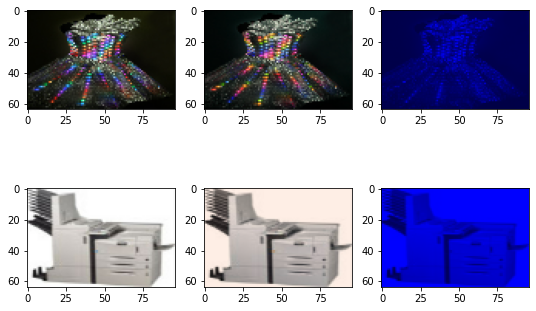

In [124]:
ae = SparseAutoencoder(dict(
    d_enc=16,
    activation_fn=prenu,
    sparsity=0.15,
    lambda_deviation=1.,
    lambda_sparsity_kld=0.01,
))

ae(sample_images)
visualize_ae_results(sample_images, ae.encoded, ae.decoded, max_B=2) 

opt = keras.optimizers.SGD(0.002)

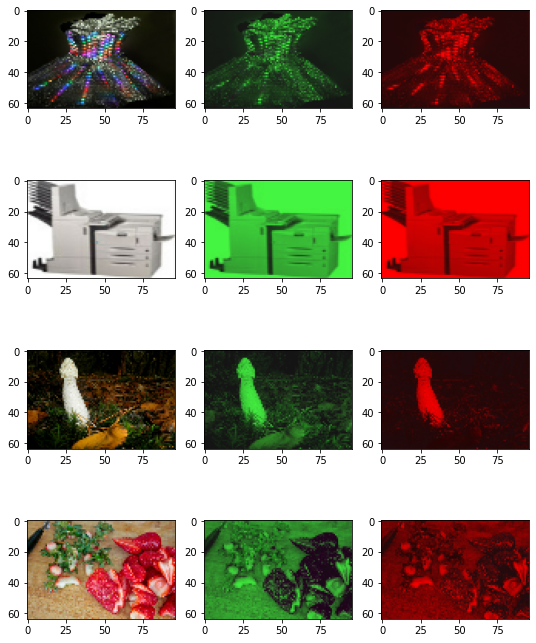

Batch 0: 
loss: 0.17451
Batch 1: 
loss: 0.17380
Batch 2: 
loss: 0.16732
Batch 3: 
loss: 0.13339
Batch 4: 
loss: 0.14498
Batch 5: 
loss: 0.16429
Batch 6: 
loss: 0.14369
Batch 7: 
loss: 0.15850
Batch 8: 
loss: 0.15361
Batch 9: 
loss: 0.14090


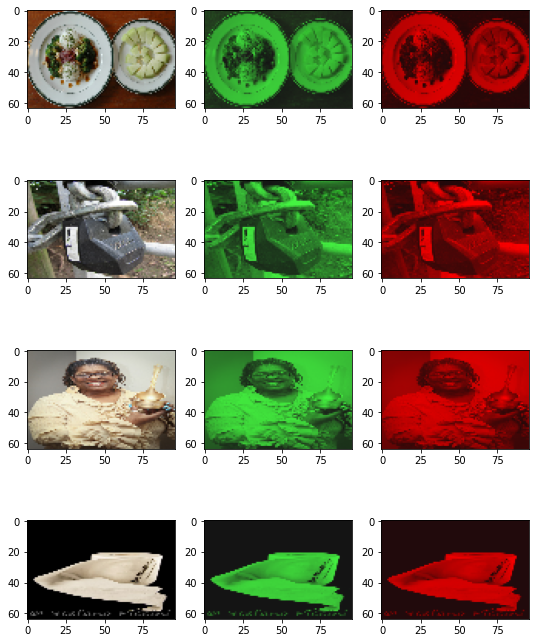

Batch 10: 
loss: 0.15409
Batch 11: 
loss: 0.17033
Batch 12: 
loss: 0.17953
Batch 13: 
loss: 0.15336
Batch 14: 
loss: 0.13991
Batch 15: 
loss: 0.15146
Batch 16: 
loss: 0.17902
Batch 17: 
loss: 0.14697
Batch 18: 
loss: 0.13720
Batch 19: 
loss: 0.14177


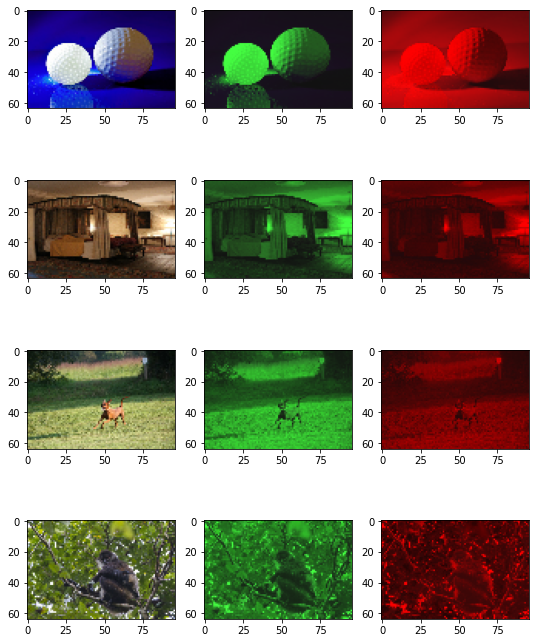

Batch 20: 
loss: 0.15638
Batch 21: 
loss: 0.17715
Batch 22: 
loss: 0.13846
Batch 23: 
loss: 0.13805
Batch 24: 
loss: 0.13990
Batch 25: 
loss: 0.14952
Batch 26: 
loss: 0.11930
Batch 27: 
loss: 0.15391
Batch 28: 
loss: 0.15297
Batch 29: 
loss: 0.15312


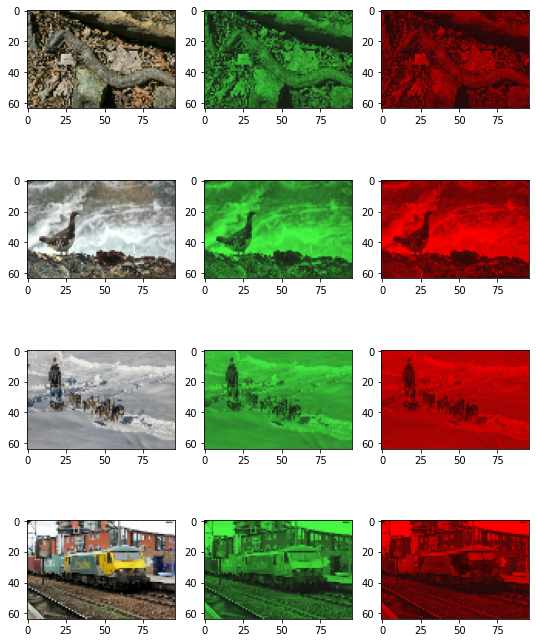

Batch 30: 
loss: 0.16817
Batch 31: 
loss: 0.14915
Batch 32: 
loss: 0.16982
Batch 33: 
loss: 0.16965
Batch 34: 
loss: 0.16155
Batch 35: 
loss: 0.12925
Batch 36: 
loss: 0.13995
Batch 37: 
loss: 0.16047
Batch 38: 
loss: 0.14357
Batch 39: 
loss: 0.15468


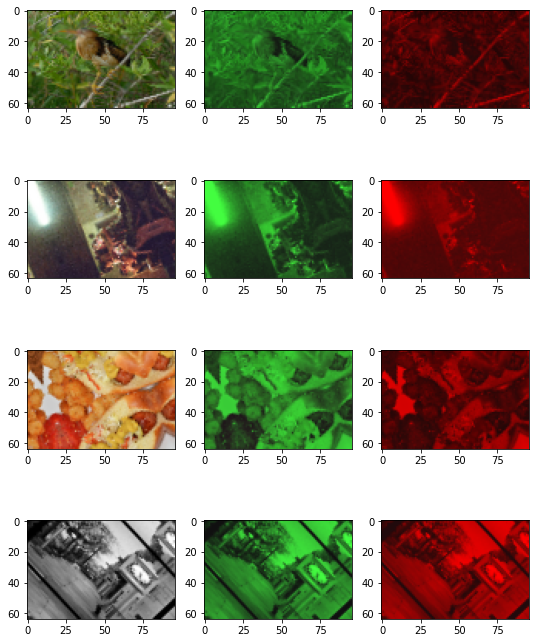

Batch 40: 
loss: 0.14792
Batch 41: 
loss: 0.13807
Batch 42: 
loss: 0.15127
Batch 43: 
loss: 0.16280
Batch 44: 
loss: 0.17266
Batch 45: 
loss: 0.15058
Batch 46: 
loss: 0.13796
Batch 47: 
loss: 0.14855
Batch 48: 
loss: 0.17634
Batch 49: 
loss: 0.14433


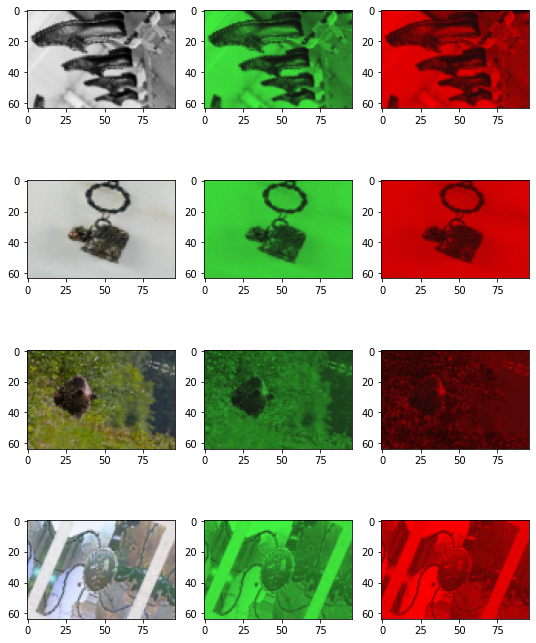

Batch 50: 
loss: 0.13208
Batch 51: 
loss: 0.13897
Batch 52: 
loss: 0.15125
Batch 53: 
loss: 0.17260
Batch 54: 
loss: 0.13875
Batch 55: 
loss: 0.13509
Batch 56: 
loss: 0.13535
Batch 57: 
loss: 0.14334
Batch 58: 
loss: 0.11775
Batch 59: 
loss: 0.14756


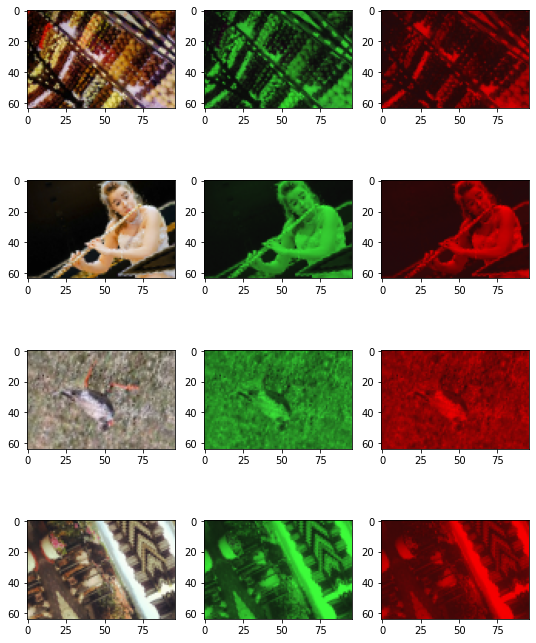

Batch 60: 
loss: 0.15109
Batch 61: 
loss: 0.14625
Batch 62: 
loss: 0.16315
Batch 63: 
loss: 0.14591


In [99]:
batch_num = 0
for batch in test_ds:
    
    with tf.GradientTape() as tape:
        _ = ae(batch)
        loss = sum(ae.losses)
    grads = tape.gradient(loss, ae.trainable_weights)
    opt.apply_gradients(zip(grads, ae.trainable_weights))
    
    if batch_num % 10 == 0:
        visualize_ae_results(batch, ae.encoded, ae.decoded, max_B=4)    
        
    print('Batch %d: \nloss: %0.5f' % (batch_num, loss));
    batch_num += 1

In [64]:
glom.summary()

Model: "glom"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
L0-L1 (ManyToManyDense)      multiple                  0         
_________________________________________________________________


ValueError: You tried to call `count_params` on L1-L2, but the layer isn't built. You can build it manually via: `L1-L2.build(batch_input_shape)`.

image 0: b'/home/jacob/tensorflow_datasets/downloads/extracted/TAR_GZ.s3-us-west-2_imagene_imagene-top-imagesheSs4w8_DWYBUgYiVLh1ndpmJnsn9-wP2NV2jxBzoEs.tar.gz/imagenetv2-top-images-format-val/601/088bc46ad752e10f0e3fbe2c6dbafbb3bad3b4d9.jpeg'
t:0


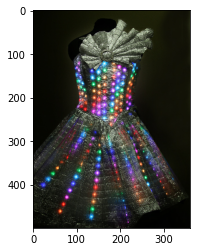

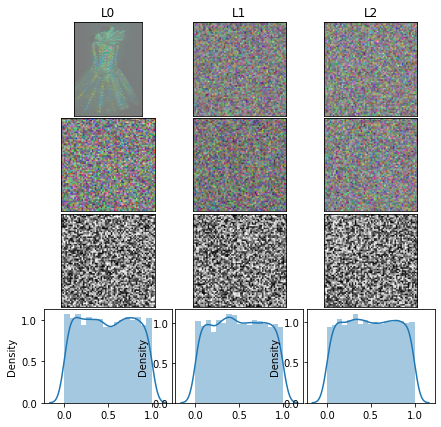

1


AssertionError: 

In [62]:
N_images = 2
T = 20

glom = GLOM(
    input_layers=['L0'],
    output_layers=['L0'],
    layer_sizes=dict(L0=(64, 64, 16), 
                     L1=(64, 64, 64), 
                     L2=(64, 64, 64)),
    connections=[
        dict(inputs=['L0'], outputs=['L1'], type='bu'),
        dict(inputs=['L1'], outputs=['L2'], type='bu'),
        dict(inputs=['L2'], outputs=['L0'], type='td'),
        #dict(inputs=['L1'], outputs=['L0'], type='td'),
    ],
    hparams=dict(
        a_bu=0.5,
        b_bu=0.,
        a_lat=1.0,
        b_lat=0.,
        a_td=0.2,
        b_td=0.,
        lr_awake=0.02,
        lr_asleep=0.005,
    ),
    name='glom'
)
glom.set_mode('awake')


layer_state_series = [glom.get_initial_state()]

for i, ex in enumerate(test_ds.take(N_images)):
    print(f'image {i}: {ex["file_name"].numpy()}')
    train_image = ex['image']
    plt.imshow(train_image)
    
    
    train_image = tf.cast(train_image, tf.float32)
    train_image = train_image / 255.
    train_image = train_image[None, ...]
    enc_train_image = encoder(train_image)
    
    for t in range(T):
        layer_state_series.append(layer_state_series[-1])
        layer_state_series[-1]['L0']['x'] = enc_train_image
        
        print(f't:{t}')
        view_layer_states2(layer_state_series[-1])
        layer_state_series[-1] = glom(layer_state_series[-1])

In [15]:
L0 = layer_state_series[1]['L0']
L1 = layer_state_series[1]['L1']
L2 = layer_state_series[1]['L2']

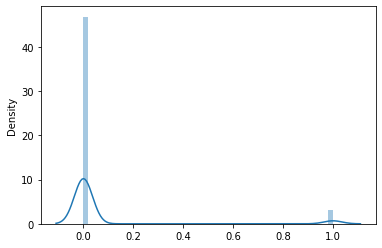

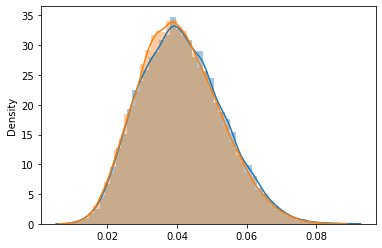

In [16]:
distplot(L0['x'])
plt.show()
distplot(L1['x']) 
distplot(L2['x'])